Just to check our filtering really works

In [1]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
TRAIN_PATH = '../data/data_clean2'

In [3]:
def load_and_preprocess(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.png"
    img = cv2.imread(os.path.join(TRAIN_PATH, img_fname), cv2.IMREAD_GRAYSCALE)
    assert img is not None
    mask = cv2.imread(os.path.join(TRAIN_PATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    assert mask is not None
    
    #newsize = (img.shape[1] / 4, img.shape[0] / 4)
    #newsize = (128, 128)
    #img = cv2.resize(img, newsize)
    #mask = cv2.resize(mask, newsize)
    mask = (mask > 128).astype(np.float32)
    
    # TODO: Could subtract mean as on fimg above
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask


def load_patient(pid):
    fnames = [os.path.basename(fname) for fname in glob.glob(TRAIN_PATH + "/%d_*.png" % pid) if 'mask' not in fname]
    imgs, masks = zip(*map(load_and_preprocess, fnames))
    return imgs, masks, fnames

In [4]:
imgs, masks, fnames = load_patient(6)

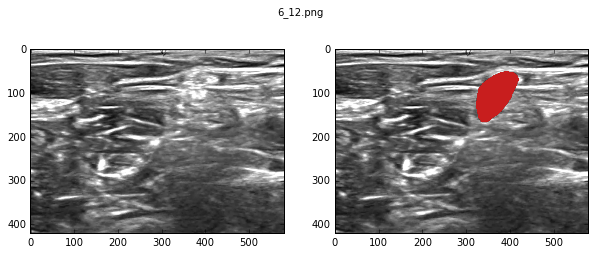

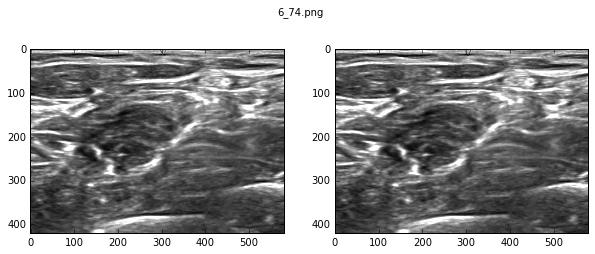

In [5]:
def show(i):
    pl.figure(figsize=(10, 4))
    pl.suptitle(fnames[i])
    pl.subplot(121)
    pl.imshow(imgs[i], cmap=cm.gray)
    
    pl.subplot(122)
    pl.imshow(imgs[i], cmap=cm.gray)
    h, w = imgs[i].shape[:2]
    overlay = np.zeros((h, w, 4), dtype=np.uint8)
    overlay[masks[i] > 0, :] = (200, 30, 30, 255)
    pl.imshow(overlay, alpha=1)
    
show(35)
show(36)

# Finding similar images with different masks

In [6]:
import skimage

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

#hists = np.array([np.histogram(img, bins=np.linspace(0, 1, 20))[0] for img in imgs])
hists = np.array(map(compute_img_hist, imgs))
hists.shape

(120, 189)

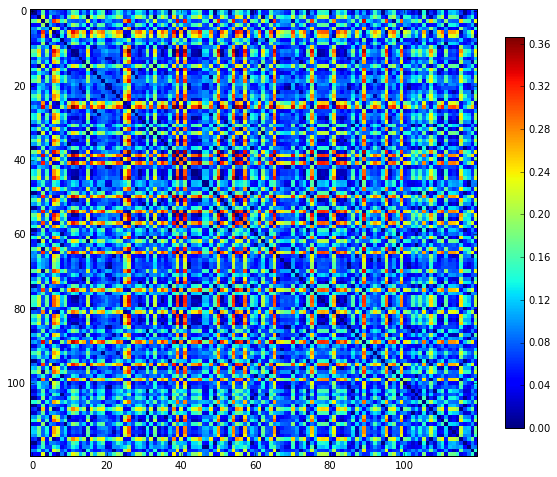

In [7]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

pl.figure(figsize=(10, 10))
pl.imshow(D, interpolation='nearest')
pl.colorbar(shrink=0.7)

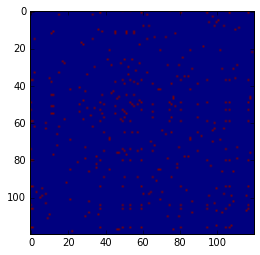

In [8]:
close_pairs = D + np.eye(D.shape[0]) < 0.008
pl.imshow(close_pairs)

In [9]:
close_ij = np.transpose(np.nonzero(close_pairs))
print close_ij.shape

(346, 2)


In [10]:
incoherent_ij = [(i, j) for i, j in close_ij if utils.dice_coefficient(masks[i], masks[j]) < 0.2]
incoherent_ij = np.array(incoherent_ij)
print incoherent_ij.shape

(20, 2)


0.00594978954651
0.0


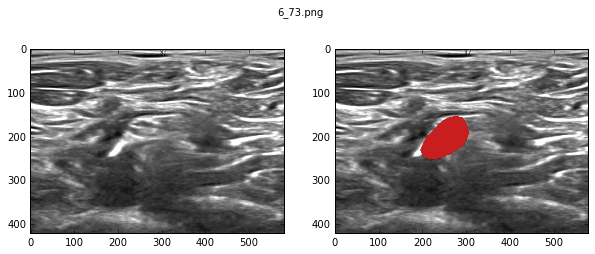

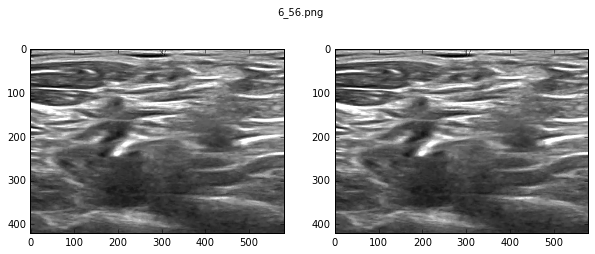

In [11]:
i, j = incoherent_ij[np.random.randint(incoherent_ij.shape[0])]

print D[i, j]
print utils.dice_coefficient(masks[i], masks[j])

show(i)
show(j)